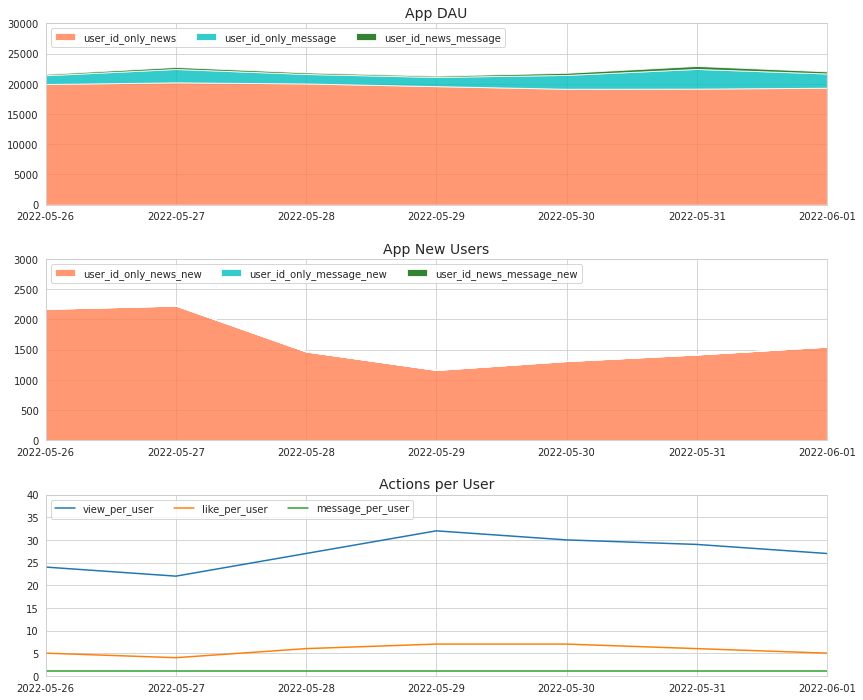

In [7]:
import pandas as pd
from CH import Getch
import pandahouse
from datetime import date,timedelta, datetime
import telegram
import seaborn as sns
import matplotlib.pyplot as plt
import io
import numpy as np

sns.set_style("whitegrid")


#Достаем данные из базы
full_data = Getch(
'''
with t1 as (select user_id
                    ,toDate(time) as day
                    ,source
                    ,action
                    ,count(post_id) as action_value
                from simulator_20220520.feed_actions
                group by user_id, day,source, action
    ),
    t2 as (select user_id
                ,toDate(time) as day
                ,source
                ,'message' as action
                ,count(user_id) as action_value
            from simulator_20220520.message_actions
            group by user_id,day,source
    )
select tt.* 
from   (select user_id
                ,source
                ,day
                ,sumIf(action_value,action ='like') as like
                ,sumIf(action_value,action='view') as view
                ,sumIf(action_value,action='message') as message
                ,if(view > 0, 1, 0) as user_id_news
                ,if(message  > 0, 1, 0) as user_id_message
                ,if(view > 0 and message > 0, 1,0) as user_id_news_message
        from (select * from t1 union all select * from t2) as  t
 where day != today()
group by user_id, source,day) tt

    
'''
    ).df

# считаем дату начала/конца для каждого юзера
full_data_users = full_data.groupby('user_id', as_index = False)[['day']]\
                            .agg(['min','max'])

stats = ['min','max']
full_data_users.columns = ['date_{}'.format(stat) for stat in stats]
full_data_users = full_data_users.reset_index()


#мерджим и добавляем новые колонки (быстрее было бы сделать в sql, но я тренировалась в питоне)
mapping = {True:1, False:0}
full_data = full_data.merge(full_data_users, how = 'left', on = 'user_id')
full_data['user_id_only_news'] = full_data[['view','message']].apply(lambda x: 1 if (x['message'] == 0 and x['view'] > 0 ) else 0,axis=1)
full_data['user_id_only_message'] = full_data[['view','message']].apply(lambda x: 1 if (x['message'] > 0 and x['view'] == 0 ) else 0,axis=1)
full_data['new_user'] = (full_data['day'] == full_data['date_min']).map(mapping)
full_data['user_ads'] = (full_data['source'] == 'ads').map(mapping)
full_data['user_id_only_news_new'] = full_data[['new_user','user_id_only_news']].apply(lambda x: 1 if (x['new_user'] == 1 and x['user_id_only_news'] == 1) else 0,axis=1)
full_data['user_id_only_message_new'] = full_data[['new_user','user_id_only_message']].apply(lambda x: 1 if (x['new_user'] == 1 and x['user_id_only_message'] == 1) else 0,axis=1)
full_data['new_user_organic'] = full_data[['new_user','source']].apply(lambda x: 1 if (x['new_user'] == 1 and x['source'] == 'organic') else 0,axis=1)


full_data_new = full_data.groupby('day', as_index = False).agg({'user_id':'nunique',
                                                                    'new_user':'sum',
                                                                    'new_user_organic':'sum',
                                                                    'user_ads':'sum',                                                        
                                                                    'like':'sum',
                                                                    'view':'sum',
                                                                    'message':'sum',
                                                                    'user_id_news':'sum',
                                                                    'user_id_message':'sum',
                                                                    'user_id_news_message':'sum',
                                                                    'user_id_only_news_new':'sum',
                                                                    'user_id_only_message_new':'sum'                                                                
                                                               }).sort_values('day', ascending =True)\
                                                        .rename(columns = {'user_id' : 'dau'})
full_data_new['user_id_news_message_new'] = full_data_new['new_user'] - full_data_new['user_id_only_news_new'] - full_data_new['user_id_only_message_new'] 
full_data_new['user_id_only_news'] = full_data_new['user_id_news'] - full_data_new['user_id_news_message']
full_data_new['user_id_only_message'] = full_data_new['user_id_message'] - full_data_new['user_id_news_message'] 
full_data_new['CTR'] = (full_data_new['like']/full_data_new['view']).round(2)
full_data_new['actions_per_user'] = ((full_data_new['view']+full_data_new['like']+full_data_new['message'])/full_data_new['dau']).round(0)
full_data_new['view_per_user'] = ((full_data_new['view'])/full_data_new['dau']).round(0)
full_data_new['like_per_user'] = ((full_data_new['like'])/full_data_new['dau']).round(0)
full_data_new['message_per_user'] = ((full_data_new['message'])/full_data_new['dau']).round(0)
full_data_new['k-factor'] = (full_data_new['new_user_organic']/(full_data_new['dau']-full_data_new['new_user'])).round(4)
full_data_new['ads_traffic'] = (full_data_new['user_ads']/full_data_new['dau']).round(2)
full_data_new.sort_values('day', ascending =True)

#считаем данные для "липкости"
StickyFactor = Getch(
'''
with t1 as (select user_id
                    ,toDate(time) as day
                    ,source
                    ,action
                    ,count(post_id) as action_value
                from simulator_20220520.feed_actions
                group by user_id, day,source, action
),
 t2 as (select user_id
                ,toDate(time) as day
                ,source
                ,'message' as action
                ,count(user_id) as action_value
            from simulator_20220520.message_actions
            group by user_id,day,source
)
    
select day
        ,dau
        ,mau
        ,dau/mau as sticky_factor
from
  (select  distinct day
          ,count(distinct user_id) over(partition by day) as dau
          ,count(distinct user_id) over (order by day range between 30 preceding and  --current row ) as mau
           1 preceding) as mau                    --,count(distinct user_id) over(partition by day)/mau as sticky_factor
from (select * from t1 union all select * from t2) ) as t 
order by day desc
'''
    ).df


#на  какие даты нужны будут графики/данные
yesterday = (date.today() - timedelta(days=1)).strftime('%Y-%m-%d')
week = (date.today() - timedelta(days=7)).strftime('%Y-%m-%d')

full_data_yesterday = full_data_new[full_data_new.day == yesterday].reset_index()
stickyfactor_yesterday =StickyFactor[StickyFactor.day == yesterday].reset_index()
full_data_week = full_data_new[full_data_new.day >= week].reset_index()

dau = full_data_week[['day','user_id_only_news','user_id_only_message','user_id_news_message']]
new_users = full_data_week[['day','user_id_only_news_new','user_id_only_message_new','user_id_news_message_new']]
actions = full_data_week[['day','view_per_user','like_per_user','message_per_user']]

# Decide Colors 
mycolors = ['coral', 'c', 'darkgreen']

text = '''
        Data report for {}: 
        App DAU                               {}
        News DAU                            {}
        Message DAU                       {} 
        News & Message DAU        {}
        App New Users                    {}
        Actions per user                  {}
        Ads_traffic                            {}
        Sticky Factor                         {}
        
        '''.format(yesterday,
                full_data_yesterday.dau[0],
                full_data_yesterday.user_id_news[0].astype(int),
                full_data_yesterday.user_id_message[0].astype(int),
                full_data_yesterday.user_id_news_message[0].astype(int),
                full_data_yesterday.new_user[0],
                full_data_yesterday.actions_per_user[0].astype(int),
                #full_data_yesterday['k-factor'][0],
                full_data_yesterday.ads_traffic[0],
                stickyfactor_yesterday.sticky_factor[0].round(2))


def send_report(chat=None):
    chat_id = chat or 400853280
    token = '5368668226:AAGZNDxvxf83GApSiJqi5ahEkIHDXzV52Nw'
    bot = telegram.Bot(token = token) 

    # Draw Plot and Annotate
    #fig, ax = plt.subplots(1,1,figsize=(16, 7), dpi= 80)
    plt.figure(figsize=(14, 12))

    # ГРАФИК DAU
    plt.subplot (3, 1, 1)
    plt.subplots_adjust(wspace=0.3, hspace=0.3)
    columns = dau.columns[1:]
    labs = columns.values.tolist()

    # Prepare data
    x  = dau['day'].values
    y0 = dau['user_id_only_news'].values.tolist()
    y1 = dau['user_id_only_message'].values.tolist()
    y2 = dau['user_id_news_message'].values.tolist()

    y = np.vstack([y0, y1, y2])

    # Plot for each column
    ax = plt.gca()
    ax.stackplot(x, y , labels=labs, colors=mycolors, alpha=0.8)

    # Decorations
    ax.set_title('App DAU', fontsize=14)
    ax.set(ylim=[0, 30000])
    ax.legend(fontsize=10, ncol=4,loc ='upper left')
    plt.xticks(x[::1], fontsize=10, horizontalalignment='center')
    #plt.yticks(np.arange(0, 30000, 5000), fontsize=10)
    plt.xlim(x[0], x[-1])



    # ГРАФИК НОВЫХ ПОЛЬЗОВАТЕЛЕЙ
    plt.subplot (3, 1, 2)
    plt.subplots_adjust(wspace=0.3, hspace=0.3)
    columns = new_users.columns[1:]
    labs = columns.values.tolist()

    # Prepare data
    x  = new_users['day'].values
    y0 = new_users['user_id_only_news_new'].values.tolist()
    y1 = new_users['user_id_only_message_new'].values.tolist()
    y2 = new_users['user_id_news_message_new'].values.tolist()

    y = np.vstack([y0, y1, y2])

    # Plot for each column
    ax = plt.gca()
    ax.stackplot(x, y , labels=labs, colors=mycolors, alpha=0.8)

    # Decorations
    ax.set_title('App New Users', fontsize=14)
    ax.set(ylim=[0, 3000])
    ax.legend(fontsize=10, ncol=4,loc ='upper left')
    plt.xticks(x[::1], fontsize=10, horizontalalignment='center')
    #plt.yticks(np.arange(0, 3000, 500), fontsize=10)
    plt.xlim(x[0], x[-1])

    # график действий на одного пользователя
    plt.subplot (3, 1, 3)
    plt.subplots_adjust(wspace=0.3, hspace=0.3)
    ax = plt.gca()
    sns.lineplot(data = full_data_week, x = 'day' , y = 'view_per_user')
    sns.lineplot(data = full_data_week, x = 'day' , y = 'like_per_user')
    sns.lineplot(data = full_data_week, x = 'day' , y = 'message_per_user')
    plt.legend(labels = ['view_per_user','like_per_user','message_per_user'],fontsize=10, ncol=4,loc ='upper left')
    ax.set(ylim=[0, 40])
    #plt.yticks(np.arange(0, 800000, 150000), fontsize=10)
    plt.title('Actions per User', fontsize=14)
    plt.xticks(rotation=0)
    plt.xlabel('')
    plt.ylabel('')
    plt.xlim(x[0], x[-1])
    
    #отправка графиков
    plot_object = io.BytesIO()
    plt.savefig(plot_object)
    plot_object.name = 'plot.png'
    #Перемещает указатель чтения/записи в файле.
    plot_object.seek(0)
    plt.close

    bot.sendPhoto(chat_id = chat_id, photo = plot_object, caption = text)
    
try:
    send_report()
except Exception as e:
    print(e)